# Device RB with LF

Perform RB with the LF code without enforcing the full layer barrier, which is effectively direct RB.

Note this can be lengthy to run on a full 127+ qubit device. Parameters given need to be adjusted depending on the device.

There is no purity option with this code.

New: Option to run RZZ benchmarking

In [ ]:
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import RZZGate

from qiskit_experiments.framework import (
    BatchExperiment,
    ExperimentData,
)
from qiskit_experiments.library.randomized_benchmarking import (
    LayerFidelity,
    LayerFidelityUnitary,
)

from qiskit_device_benchmarking.utilities import graph_utils as gu
from qiskit_device_benchmarking.utilities import layer_fidelity_utils as lfu

In [52]:
# enter your account name here
acct_name = "my_account"

service = QiskitRuntimeService(name=acct_name)
backend_real = service.backend("ibm_fez", use_fractional_gates=True)
nq = backend_real.configuration().n_qubits
coupling_map = backend_real.configuration().coupling_map

### Use RustworkX and Graph Utilities to Build Sets

Code below uses some of the graph utilities in the package to pull out several sets of isolated two qubit pairs.

In [53]:
# build a set of gates
G = gu.build_sys_graph(nq, coupling_map)
# get all length 2 paths in the device
paths = rx.all_pairs_all_simple_paths(G, 2, 2)
# flatten those paths into a list from the rustwork x iterator
paths = gu.paths_flatten(paths)
# remove permutations
paths = gu.remove_permutations(paths)
# convert to the coupling map of the device
paths = gu.path_to_edges(paths, coupling_map)
# make into separate sets
sep_sets = gu.get_separated_sets(G, paths, min_sep=2)

# convert the sets from list to tuple
for i in range(len(sep_sets)):
    sep_sets[i] = [tuple(j) for j in sep_sets[i]]

In [54]:
%%time
# rb of all the edges in parallel
rb_batch_list = []

# RB options
# Note that because these lengths are per layer to compare to an equivalent
# 2Q RB run you need to do 1.5x as many
lengths = [1, 10, 20, 50, 100, 150, 250, 500, 1000]

num_samples = 3

# rb_type
# 0: standard 2Q RB
# 1: standard 1Q RB
# 2: RZZ 2Q RB (remember to set use_fractional_gates=True)

rb_type = 2


if rb_type == 1:
    lengths = [10, 100, 250, 1000, 2500, 5000]

print(lengths)

if "ecr" in backend_real.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend_real.configuration().basis_gates:
    twoq_gate = "cz"

if rb_type == 2:
    nangles = 100
    rzz_gate_lst = []
    for i in range(nangles):
        # can do this
        # qc = QuantumCircuit(2)
        # qc.rzz(np.pi/2/nangles*(i+1),0,1)
        # rzz_gate_lst.append(qc.to_instruction())

        # or
        rzz_gate_lst.append(RZZGate(np.pi / 2 / nangles * (i + 1)))

# go through for each of the edge sets
for ii in range(len(sep_sets)):
    qlist = [int(i) for i in np.unique(sep_sets[ii])]

    if rb_type == 1:
        rb_exp = LayerFidelity(
            physical_qubits=qlist,
            two_qubit_layers=[[]],
            lengths=lengths,
            num_samples=num_samples,
            backend=backend_real,
            layer_barrier=False,
        )

        # uncomment if want to use a 1Q fixed decomposition
        # rb_exp.experiment_options.clifford_synthesis_method = '1Q_fixed'

    elif rb_type == 0:
        rb_exp = LayerFidelity(
            physical_qubits=qlist,
            two_qubit_layers=[sep_sets[ii]],
            lengths=lengths,
            num_samples=num_samples,
            backend=backend_real,
            layer_barrier=False,
        )

        # uncomment if want to use a 1Q fixed decomposition
        # rb_exp.experiment_options.clifford_synthesis_method = '1Q_fixed'

    elif rb_type == 2:
        rb_exp = LayerFidelityUnitary(
            physical_qubits=qlist,
            two_qubit_layers=[sep_sets[ii]],
            two_qubit_gates=rzz_gate_lst,
            two_qubit_basis_gates=["rzz"],
            lengths=lengths,
            num_samples=num_samples,
            backend=backend_real,
            layer_barrier=False,
        )

        # uncomment if want to use a 1Q fixed decomposition
        # rb_exp.experiment_options.clifford_synthesis_method = '1Q_fixed'

    else:
        raise ValueError("No rb_type: %d is defined" % rb_type)

    rb_exp = LayerFidelity(
        physical_qubits=qlist,
        two_qubit_layers=[sep_sets[ii]],
        lengths=lengths,
        num_samples=num_samples,
        backend=backend_real,
        layer_barrier=False,
    )

    rb_exp.set_experiment_options(max_circuits=(num_samples * len(lengths)))
    rb_exp.set_run_options(shots=200)

    rb_batch_list.append(rb_exp)


# batch all of them together
full_rb_exp = BatchExperiment(
    rb_batch_list, backend=backend_real, flatten_results=False
)
full_rb_exp.set_experiment_options(
    max_circuits=len(lengths) * num_samples * len(sep_sets)
)
full_rb_exp.set_run_options(shots=200)

# uncomment to run as a Batch Experiment
# rb_data = full_rb_exp.run()
# print(rb_data.job_ids)

[1, 10, 20, 50, 100, 150, 250, 500, 1000]
CPU times: user 167 ms, sys: 6.09 ms, total: 173 ms
Wall time: 575 ms


In [55]:
# Run as individual experiments
rb_data_lst = []
for rb_exp in rb_batch_list:
    rb_data_lst.append(rb_exp.run())
    print(rb_data_lst[-1].job_ids)

['d1aaml47tq0c73db99kg']
['d1aamq7d1s7s73aeqc0g']
['d1aamv7d1s7s73aeqc80']
['d1aan36c0o9c73anhdp0']
['d1aan56mm8oc73a0c3o0']


In [8]:
# Run this cell if you want to reload data from a previous job(s)
if 0:
    # List of job IDs for the experiment
    job_ids = [""]

    rb_data = ExperimentData(experiment=full_rb_exp)
    rb_data.add_jobs([service.job(job_id) for job_id in job_ids])
    full_rb_exp.analysis.run(rb_data, replace_results=True)

    # Block execution of subsequent code until analysis is complete
    rb_data.block_for_results()

### Analyze the Data

First pull all the data into several giant lists. Then plot. Make the jobs have run first which can be probed with `tomo_data.analysis_status()`

In [61]:
rb_data_lst[-2].analysis_status()

<AnalysisStatus.DONE: 'analysis callback has successfully run'>

[0, 0]


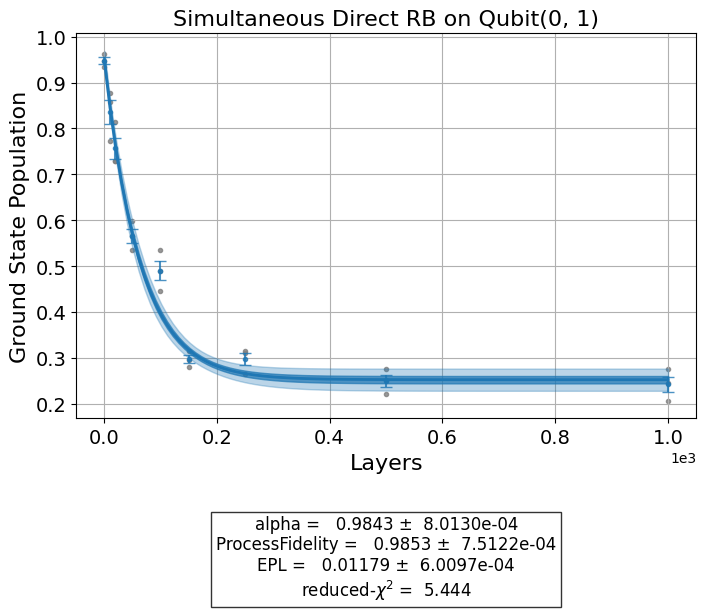

In [63]:
# Plot the data
# Input the edge to plot here
fig_edge = tuple([0, 1])
fig_id = []
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        if fig_edge == sep_sets[i][j]:
            fig_id = [i, j]
print(fig_id)
rb_data_lst[fig_id[0]].figure(fig_id[1])

### Extract RB Errors
Load the dataframe and extract the errors from the fits 

In [ ]:
# Load the RB Error into a list


set_list = []
rb_err = []
pur_rb_err = []
gate_err = []
gate_err_old = []
back_prop = backend_real.properties()

for i in range(len(sep_sets)):
    # get the data frame
    # df = rb_data.child_data(i).analysis_results(dataframe=True)
    df = rb_data_lst[i].analysis_results(dataframe=True)
    gate_errs2 = lfu.df_to_error_dict(df, sep_sets[i])

    for j in range(len(sep_sets[i])):
        set_list.append(sep_sets[i][j])
        rb_err.append(gate_errs2["%d_%d" % (sep_sets[i][j][0], sep_sets[i][j][1])])
        gate_err.append(back_prop.gate_error(twoq_gate, set_list[-1]))

        print(
            "Q%s, rb error %.2e/ reported err %.2e"
            % (sep_sets[i][j], rb_err[-1], gate_err[-1])
        )

## Plotting

Text(0.5, 1.0, 'Device Gate Errors for ibm_fez')

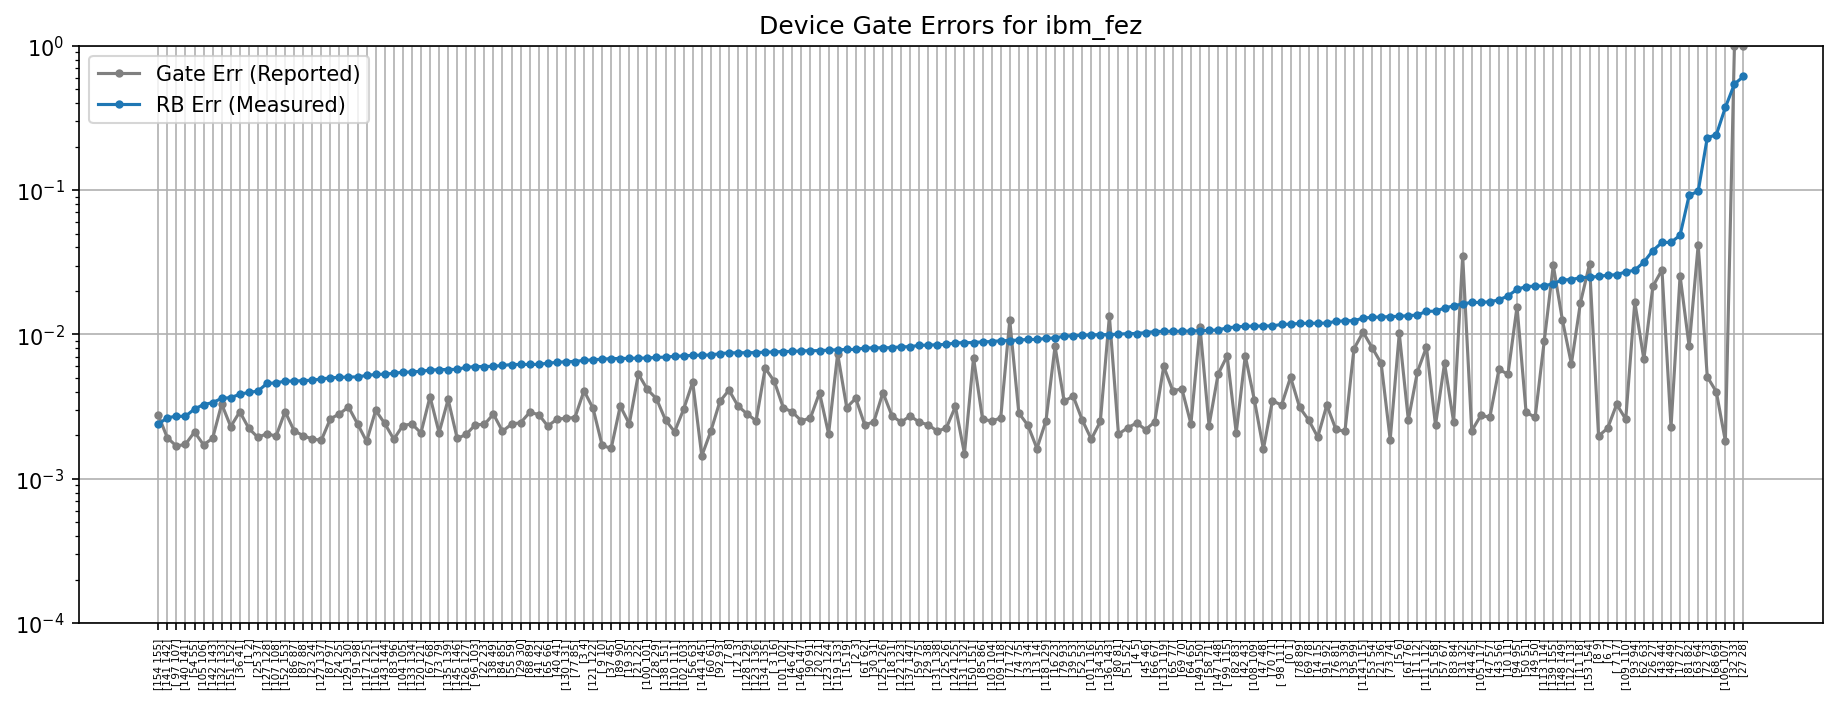

In [65]:
# plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150, figsize=[15, 5])
argind = np.argsort(rb_err)
plt.semilogy(
    range(len(set_list)),
    np.array(gate_err)[argind],
    label="Gate Err (Reported)",
    marker=".",
    color="grey",
)
plt.semilogy(
    range(len(set_list)),
    np.array(rb_err)[argind],
    label="RB Err (Measured)",
    marker=".",
)

plt.xticks(range(len(set_list)), np.array(set_list)[argind], rotation=90, fontsize=5)
plt.ylim([1e-4, 1])
plt.grid(True)
plt.legend()
plt.title("Device Gate Errors for %s" % (backend_real.name))

In [14]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()